In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, merge, Reshape, Dropout, Input, Flatten, Concatenate
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras import backend
import lightgbm as lgbm


import os
input_dir = './input/'
print(os.listdir(input_dir))

Using TensorFlow backend.


['application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
app_train_df = pd.read_csv(os.path.join(input_dir, 'application_train.csv'))
app_test_df = pd.read_csv(os.path.join(input_dir, 'application_test.csv'))
bureau_df = pd.read_csv(os.path.join(input_dir, 'bureau.csv')).drop(columns=['SK_ID_BUREAU'])
credit_card_df = pd.read_csv(os.path.join(input_dir, 'credit_card_balance.csv')).drop(columns=['SK_ID_PREV'])
pos_cash_df = pd.read_csv(os.path.join(input_dir, 'POS_CASH_balance.csv')).drop(columns=['SK_ID_PREV'])
install_df = pd.read_csv(os.path.join(input_dir, 'installments_payments.csv')).drop(columns=['SK_ID_PREV'])
prev_app_df = pd.read_csv(os.path.join(input_dir, 'previous_application.csv')).drop(columns=['SK_ID_PREV'])

print('Shape of training data:', app_train_df.SK_ID_CURR.unique().shape)
print('Shape of testing data:', app_test_df.SK_ID_CURR.unique().shape)

Shape of training data: (307511,)
Shape of testing data: (48744,)


In [13]:
def process_dataframe(df, prefix, index, recent_index, recent_index_value, numerical_nan_value=0, categorical_nan_value='NA'):
    print('Processing dataframe %s...' % prefix)
    numerical_cols = [c for c in df.columns if df[c].dtype != object and c != index]
    categorical_cols = [c for c in df.columns if df[c].dtype == object and c != index]
    
    print('Detected %d numerical features and %d categorical features' % (len(numerical_cols), len(categorical_cols)))
    
    if len(numerical_cols) > 0:
        print('Processing Lifetime Numerical')
        df_numerical_lifetime = aggregate_numeric(df[[index] + numerical_cols], index, 'mean')
        numerical_cols_prefix_lifetime = ['%s_lifetime_%s' % (prefix, c) for c in numerical_cols if c != index]
        df_numerical_lifetime.columns = [index] + numerical_cols_prefix_lifetime
        
        print('Processing Recent Numerical (36 months)')
        df_numerical_recent = aggregate_numeric(df[df[recent_index] > recent_index_value][[index] + numerical_cols], index, 'mean')
        numerical_cols_prefix_recent = ['%s_recent_%s' % (prefix, c) for c in numerical_cols if c != index]
        df_numerical_recent.columns = [index] + numerical_cols_prefix_recent
        
        df_numerical = df_numerical_lifetime.merge(df_numerical_recent, how='left', on=index)
        df_numerical.fillna(value = numerical_nan_value, inplace=True)
        
        numerical_encoders = {
            c: MinMaxScaler().fit(df_numerical[[c]]) for c in df_numerical.columns if c != index
        }
        
        for c, enc in numerical_encoders.items():
            df_numerical[[c]] = enc.transform(df_numerical[[c]])
            
    if len(categorical_cols) > 0:
        print('Processing Most Recent Categorical')
        df_categorical = most_recent_categorical(df[[index, recent_index] + categorical_cols], index, recent_index)
        categorical_cols_prefix = ['%s_recent_%s' % (prefix, c) for c in categorical_cols if c != index]
        df_categorical.columns = [index] + categorical_cols_prefix
        df_categorical.fillna(value = categorical_nan_value, inplace=True)
        
        categorical_encoders = {
            c: LabelEncoder().fit(list(df_categorical[c].unique())) for c in categorical_cols_prefix
        }
        
        for c, enc in categorical_encoders.items():
            df_categorical[[c]] = enc.transform(df_categorical[[c]])
            
        df_return = df_numerical.merge(df_categorical, how='inner', on=index)
    else:
        df_return = df_numerical
        categorical_encoders = {}
    
    return (
        df_return,
        {'%s_numerical' % prefix: numerical_encoders, '%s_categorical' % prefix: categorical_encoders}
    )

def merge_dataframe_list(dfs, index):
    df_merge = None
    for i, df in enumerate(dfs):
        if i == 0:
            df_merge = df
        else:
            df_merge.merge(df, how='left', on=index)
            
    return df

def most_recent_app(df, index, recent_index):
#     recent = df.groupby(index)[recent_index].idxmax()
#     df = df.loc[recent, :]
    numerical_columns = [c for c in df.columns if df[c].dtype != object and c != index]
    numerical_encoders = {
        c: MinMaxScaler().fit(df[[c]]) for c in numerical_columns
    }
    for c, enc in numerical_encoders.items():
        df[[c]] = enc.transform(df[[c]])
        
    categorical_columns = [c for c in df.columns if df[c].dtype != object and c == index]
    categorical_encoders = {
        c: LabelEncoder().fit(list(df[c].unique())) for c in categorical_columns
    }
    for c, enc in categorical_encoders.items():
        df[[c]] = enc.transform(df[[c]])
    print(numerical_encoders)
    print(categorical_encoders)
    
    
    return df

def aggregate_numeric(df, index, method):
    return df.groupby(index).agg(method).reset_index()

def most_recent_categorical(df, index, recent_index):
    recent = df.groupby(index)[recent_index].idxmax()
    categories = [index] + df.columns[df.dtypes == 'object'].tolist()
    return df.loc[recent, categories]

In [14]:
previous_app_proc = most_recent_app(prev_app_df, 'SK_ID_CURR', 'DAYS_LAST_DUE')

/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: y contains previously unseen labels: nan

In [ ]:
previous_app_proc

In [22]:
bureau_proc, bureau_encoders = process_dataframe(bureau_df, 'bureau', 'SK_ID_CURR', 'DAYS_CREDIT', -1095)
credit_proc, credit_encoders = process_dataframe(credit_card_df, 'credit', 'SK_ID_CURR', 'MONTHS_BALANCE', -36)
cash_proc, cash_encoders = process_dataframe(pos_cash_df, 'cash', 'SK_ID_CURR', 'MONTHS_BALANCE', -36)
install_proc, install_encoders = process_dataframe(install_df, 'install', 'SK_ID_CURR', 'DAYS_INSTALMENT', -1095)
previous_proc, previous_encoders = process_dataframe(prev_app_df, 'previous', 'SK_ID_CURR', 'DAYS_LAST_DUE', -1095)

previous_app_proc = most_recent_all(prev_app_df, 'SK_ID_CURR', 'DAYS_LAST_DUE')

Processing dataframe bureau...
Detected 12 numerical features and 3 categorical features
Processing Lifetime Numerical
Processing Recent Numerical (36 months)
Processing Most Recent Categorical


KeyboardInterrupt: 

In [20]:
merged_df = merge_dataframe_list([bureau_proc, credit_proc, cash_proc, install_proc])

Processing dataframe install...
Detected 6 numerical features and 0 categorical features
Processing Lifetime Numerical
Processing Recent Numerical (36 months)


In [5]:
# Aggregate bureau information
bureau_average_numerical = aggregate_numeric(bureau_df, 'SK_ID_CURR', 'mean')
bureau_recent_categories = most_recent_categorical(bureau_df, 'SK_ID_CURR', 'DAYS_CREDIT')

In [6]:
# Aggregate credit card information
credit_average_numerical = aggregate_numeric(credit_card_df, 'SK_ID_CURR', 'mean')
credit_recent_categories = most_recent_categorical(credit_card_df, 'SK_ID_CURR', 'MONTHS_BALANCE')

In [7]:
# Aggregate pos 
pos_average_numerical = aggregate_numeric(pos_cash_df, 'SK_ID_CURR', 'mean')
pos_recent_categories = most_recent_categorical(pos_cash_df, 'SK_ID_CURR', 'MONTHS_BALANCE')

In [8]:
# Aggregate installments 
install_average_numerical = aggregate_numeric(install_df, 'SK_ID_CURR', 'mean')

In [9]:
#Previous applications
previous = most_recent_all(prev_app_df, 'SK_ID_CURR', 'DAYS_LAST_DUE')
previous_average_numerical = aggregate_numeric(prev_app_df, 'SK_ID_CURR', 'mean')

/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [10]:
current_numerical = list(set(['SK_ID_CURR'] + app_train_df.columns[app_train_df.dtypes != 'object'].tolist()))
current_categories = list(set(['SK_ID_CURR'] + app_train_df.columns[app_train_df.dtypes == 'object'].tolist()))
previous_numerical = list(set(['SK_ID_CURR'] + previous.columns[previous.dtypes != 'object'].tolist()))
previous_categories = list(set(['SK_ID_CURR'] + previous.columns[previous.dtypes == 'object'].tolist()))

merged_numerical = app_train_df[current_numerical].merge(
    previous[previous_numerical], how='left', on='SK_ID_CURR', suffixes=('', '_APP_RECENT')).merge(
    previous_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_APP_AVG')).merge(
    bureau_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_BUREAU_AVG')).merge(
    credit_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_CREDIT_AVG')).merge(
    pos_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_POS_AVG')).merge(
    install_average_numerical, how='left', on='SK_ID_CURR', suffixes=('', '_INSTALL_AVG'))
merged_numerical.fillna(0, inplace=True)

merged_categories = app_train_df[current_categories].merge(
    previous[previous_categories], how='left', on='SK_ID_CURR', suffixes=('', '_APP_RECENT')).merge(
    bureau_recent_categories, how='left', on='SK_ID_CURR', suffixes=('', '_BUREAU_CAT')).merge(
    credit_recent_categories, how='left', on='SK_ID_CURR', suffixes=('', '_CREDIT_CAT')).merge(
    pos_recent_categories, how='left', on='SK_ID_CURR', suffixes=('', '_POS_CAT'))
merged_categories.fillna('NA', inplace=True)

X = merged_numerical.merge(merged_categories, how='inner', on='SK_ID_CURR')
y = merged_numerical[['TARGET']]
X = X.drop(columns=['SK_ID_CURR', 'TARGET'])

# Income Ratios
# X['LOAN_INCOME_RATIO'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
# X['ANNUITY_INCOME_RATIO'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']

# # Annuity Length
# X['ANNUITY LENGTH'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']

# # Social Ratios
# X['WORKING_LIFE_RATIO'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
# X['INCOME_PER_FAM'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
# X['CHILDREN_RATIO'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']

print('Size of inputs: ', X.shape)

Size of inputs:  (307511, 222)


In [11]:
num_vals_dict = {
    c: list(X[c].unique()) for c in X.columns if X[c].dtype != object
}

cat_vals_dict = {
    c: list(X[c].unique()) for c in X.columns if X[c].dtype == object
}

cat_encoders = {}
for c in cat_vals_dict:
    enc = LabelEncoder()
    enc.fit(cat_vals_dict[c])
    cat_encoders[c] = enc
    X[c] = cat_encoders[c].transform(X[c])
    
num_cols = [c for c in num_vals_dict]
scaler = MinMaxScaler().fit(X[num_cols])
X.loc[:,num_cols] = scaler.transform(X[num_cols])

In [12]:
def build_embedding_network(numerical_inputs, categorical_inputs):
    
    model_out = []
    model_in  = []
    
    for c in categorical_inputs:
        dim = len(categorical_inputs[c])
        input_dim = Input(shape=(1,), dtype='int32', name=c)
        embed_dim = Embedding(dim, dim//2, input_length=1, name='%s_EMBED' % c)(input_dim)
        embed_dim = Dropout(0.1)(embed_dim)
        embed_dim = Reshape((dim//2,))(embed_dim)
        model_out.append(embed_dim)
        model_in.append(input_dim)
    
    input_num = Input(shape=(len(numerical_inputs),), dtype='float32', name='NUMERICAL_INPUTS')
    outputs = Concatenate(axis=1)([*model_out, input_num])
    
    outputs = (Dense(128))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.35))(outputs)
    outputs = (Dense(64))(outputs)
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(32))(outputs) 
    outputs = (Activation('relu'))(outputs)
    outputs = (Dropout(.15))(outputs)
    outputs = (Dense(1))(outputs)
    outputs = (Activation('sigmoid'))(outputs)
    
    model = Model([*model_in, input_num], outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [13]:
def preproc(df, numerical_inputs, categorical_inputs):
    return [df[c].values for c in categorical_inputs] + [df[numerical_inputs].values]

Processing Fold 1


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	cv_agg's auc: 0.766753 + 0.00471247
[100]	cv_agg's auc: 0.773144 + 0.0039211
[150]	cv_agg's auc: 0.774534 + 0.00421122
[200]	cv_agg's auc: 0.775858 + 0.00402325
[250]	cv_agg's auc: 0.777088 + 0.00401617
[300]	cv_agg's auc: 0.778443 + 0.00421917
[350]	cv_agg's auc: 0.778667 + 0.00413942
[400]	cv_agg's auc: 0.778964 + 0.00442067
[450]	cv_agg's auc: 0.778975 + 0.00427284
Optimum boost rounds = 430
Best CV result = 0.7790392049753541


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Train AUC: 0.849101
Test AUC: 0.844648


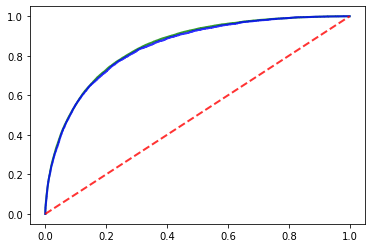

Confusion Matrix:
[[42808 13730]
 [ 1119  3846]]
Processing Fold 2


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	cv_agg's auc: 0.766753 + 0.00471247
[100]	cv_agg's auc: 0.773144 + 0.0039211
[150]	cv_agg's auc: 0.774534 + 0.00421122
[200]	cv_agg's auc: 0.775858 + 0.00402325
[250]	cv_agg's auc: 0.777088 + 0.00401617
[300]	cv_agg's auc: 0.778443 + 0.00421917
[350]	cv_agg's auc: 0.778667 + 0.00413942
[400]	cv_agg's auc: 0.778964 + 0.00442067
[450]	cv_agg's auc: 0.778975 + 0.00427284
Optimum boost rounds = 430
Best CV result = 0.7790392049753541


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Train AUC: 0.848439
Test AUC: 0.847283


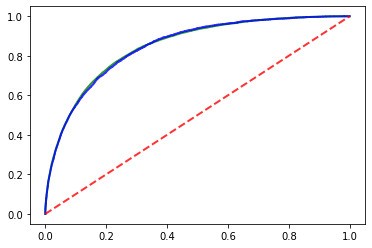

Confusion Matrix:
[[41448 15089]
 [ 1007  3958]]
Processing Fold 3


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	cv_agg's auc: 0.766753 + 0.00471247
[100]	cv_agg's auc: 0.773144 + 0.0039211
[150]	cv_agg's auc: 0.774534 + 0.00421122
[200]	cv_agg's auc: 0.775858 + 0.00402325
[250]	cv_agg's auc: 0.777088 + 0.00401617
[300]	cv_agg's auc: 0.778443 + 0.00421917
[350]	cv_agg's auc: 0.778667 + 0.00413942
[400]	cv_agg's auc: 0.778964 + 0.00442067
[450]	cv_agg's auc: 0.778975 + 0.00427284
Optimum boost rounds = 430
Best CV result = 0.7790392049753541


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Train AUC: 0.848303
Test AUC: 0.847832


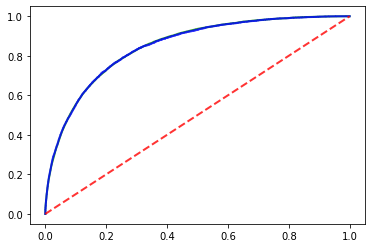

Confusion Matrix:
[[42212 14325]
 [ 1044  3921]]
Processing Fold 4


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	cv_agg's auc: 0.766753 + 0.00471247
[100]	cv_agg's auc: 0.773144 + 0.0039211
[150]	cv_agg's auc: 0.774534 + 0.00421122
[200]	cv_agg's auc: 0.775858 + 0.00402325
[250]	cv_agg's auc: 0.777088 + 0.00401617
[300]	cv_agg's auc: 0.778443 + 0.00421917
[350]	cv_agg's auc: 0.778667 + 0.00413942
[400]	cv_agg's auc: 0.778964 + 0.00442067
[450]	cv_agg's auc: 0.778975 + 0.00427284
Optimum boost rounds = 430
Best CV result = 0.7790392049753541


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Train AUC: 0.848446
Test AUC: 0.847271


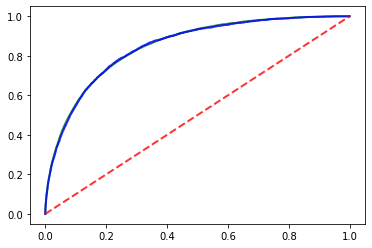

Confusion Matrix:
[[42847 13690]
 [ 1080  3885]]
Processing Fold 5


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	cv_agg's auc: 0.766753 + 0.00471247
[100]	cv_agg's auc: 0.773144 + 0.0039211
[150]	cv_agg's auc: 0.774534 + 0.00421122
[200]	cv_agg's auc: 0.775858 + 0.00402325
[250]	cv_agg's auc: 0.777088 + 0.00401617
[300]	cv_agg's auc: 0.778443 + 0.00421917
[350]	cv_agg's auc: 0.778667 + 0.00413942
[400]	cv_agg's auc: 0.778964 + 0.00442067
[450]	cv_agg's auc: 0.778975 + 0.00427284
Optimum boost rounds = 430
Best CV result = 0.7790392049753541


/usr/local/miniconda3/envs/development/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Train AUC: 0.846759
Test AUC: 0.853995


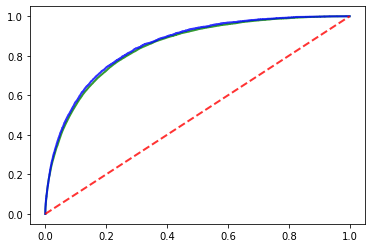

Confusion Matrix:
[[42263 14274]
 [ 1015  3950]]


In [32]:
kfold = StratifiedKFold(
    n_splits = 5,
    shuffle = True, 
    random_state=1
)

for i, (train_ind, test_ind) in enumerate(kfold.split(X, y)):
    print('Processing Fold %d' % (i+1))
    X_train = X.loc[train_ind, :]
    y_train = y.loc[train_ind, :].values
    
    X_test = X.loc[test_ind, :]
    y_test = y.loc[test_ind, :].values
    
    lgbm_train = lgbm.Dataset(data=X,
                        label=y,
                        categorical_feature=[c for c in cat_vals_dict],
                        free_raw_data=False)
    
    lgbm_params = {
        'boosting': 'dart',
        'application': 'binary',
        'learning_rate': 0.1,
        'min_data_in_leaf': 30,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.5,
        'scale_pos_weight': 2,
        'drop_rate': 0.02
    }

    cv_results = lgbm.cv(train_set=lgbm_train,
                         params=lgbm_params,
                         nfold=5,
                         num_boost_round=600,
                         early_stopping_rounds=50,
                         verbose_eval=50,
                         metrics=['auc'])
    
    optimum_boost_rounds = np.argmax(cv_results['auc-mean'])

    print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
    print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

    clf = lgbm.train(train_set=lgbm_train,
                     params=lgbm_params,
                     num_boost_round=optimum_boost_rounds)

    predicted_train = clf.predict(X_train)
    predicted_test = clf.predict(X_test)

    # Evaluations
    cv_auc  = roc_auc_score(y_train, predicted_train)
    print('Train AUC: %f' % cv_auc)
    cv_auc  = roc_auc_score(y_test, predicted_test)
    print('Test AUC: %f' % cv_auc)

    fpr, tpr, thresholds = roc_curve(y_train, predicted_train)
    plt.plot(fpr, tpr, color='g', lw=2, alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_test, predicted_test)
    plt.plot(fpr, tpr, color='b', lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.show()

    best_cutoff = np.argmax(tpr - fpr)

    y_pred = predicted_test
    y_pred[y_pred >= thresholds[best_cutoff]] = 1
    y_pred[y_pred < thresholds[best_cutoff]] = 0
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predicted_test))